# Module 8

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import skimage as ski
import skimage.filters
import skimage.segmentation
import image_analysis as anl
import imageio as img
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')

In [2]:
figfile = 'Processed/'

# 8.1 Filtering and Thresholding

In [3]:
pic = ski.color.rgb2gray(img.imread('Images/dsc_0357.jpg')).astype('double')

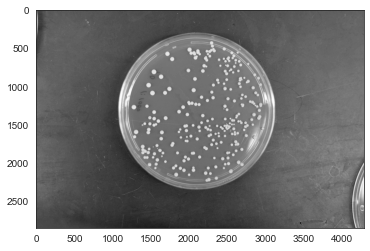

In [4]:
plt.imshow(pic, cmap = 'gray');

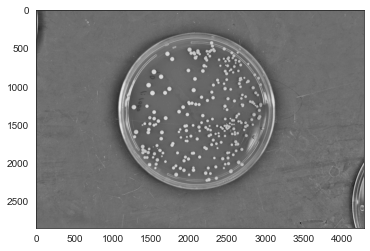

In [5]:
bkg = ski.filters.gaussian(pic,100)
pic_hp = pic-bkg
plt.imshow(pic_hp,cmap = 'gray');

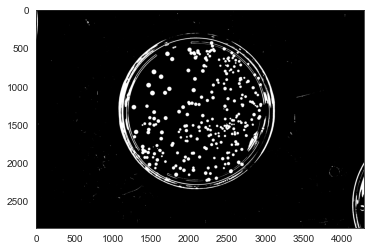

In [6]:
thresh = ski.filters.threshold_otsu(pic_hp)
pic_th = anl.thresher(pic_hp,thresh)
plt.imshow(pic_th,cmap = 'gray');

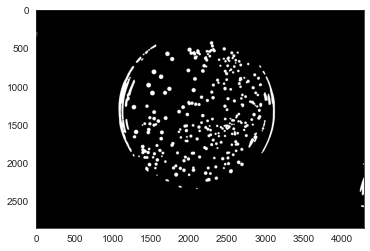

In [7]:
pic_op = ski.morphology.opening(pic_th,ski.morphology.disk(9))
plt.imshow(pic_op,cmap = 'gray');

# Labelling Thresholded Image
Label regions based on connectivity

In [8]:
labelled = ski.measure.label(pic_op,connectivity=2)

## 8.5
Remove labels where the eccentricity is really high and the area is really low

In [9]:
def remover(labelled, plotter = False):
    props = pd.DataFrame(ski.measure.regionprops_table(labelled,properties = ('label','eccentricity','area')))
    
    if plotter == True:
        plt.plot(np.log(props['area']),props['eccentricity'],'o')
        plt.xlabel('$\log(Area)$'); plt.ylabel('$e$')

    to_rem = props['label'].loc[(props['eccentricity']>0.95)|(np.log(props['area'])<5.0)]
    for i in to_rem:
        labelled = np.where(labelled==i,0,labelled)
    return labelled

In [10]:
labelled = remover(labelled)

Overlay labelled image on original and plot

In [11]:
overlayed = ski.color.label2rgb(labelled, image=pic, bg_label=0)

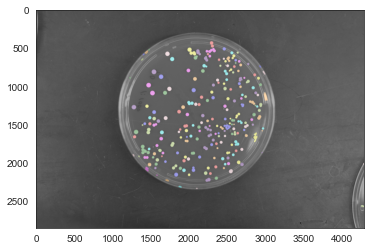

In [12]:
plt.imshow(overlayed,cmap='gray');
plt.savefig(figfile+'bacterial_colony_labelled.png',dpi=300)

# 8.1 Maxima

In [13]:
pic_brt = np.where(labelled>0,pic,0)
locs_r,locs_c,vals = anl.local_maxima(pic_brt, grid_size = 30, plot=False)

In [14]:
pic_max = np.zeros(np.shape(pic))
pic_max[locs_r,locs_c] = 1.0
pic_mod = np.where(labelled>0,pic_max,0.0)
locs_r,locs_c = np.where(pic_mod>0)

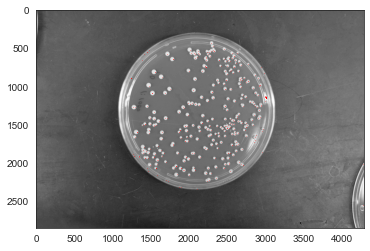

In [15]:
plt.imshow(pic,cmap='gray')
plt.plot(locs_c,locs_r,'rx',markersize=0.1);
plt.savefig(figfile+'bacterial_colony_maxima.png',dpi=300)

# 8.2 Watershed without Markers

Find gradient magnitude of the filtered image

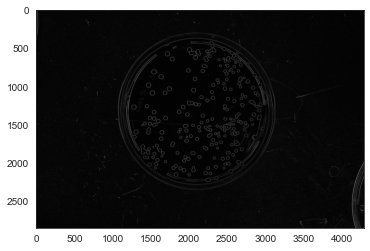

In [16]:
# Define kernel for x differences
kx = anl.sobel_kernel((5,5),0)
# Define kernel for y differences
ky = anl.sobel_kernel((5,5),1)
# Perform x convolution
x=sp.ndimage.filters.convolve(pic_hp,kx)
# Perform y convolution
y=sp.ndimage.filters.convolve(pic_hp,ky)
sobel=np.hypot(x,y)
plt.imshow(sobel,cmap='gray')
plt.show()

Apply watershed segmentation without any markers

In [17]:
shed = ski.segmentation.watershed(sobel, connectivity=2, mask=np.where(labelled>0,1,0))
shed_rgb = ski.color.label2rgb(shed,image=pic,bg_label=0)

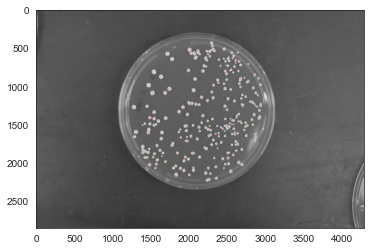

In [18]:
plt.imshow(shed_rgb);
plt.savefig(figfile+'bacterial_colony_watershed_without_markers.png',dpi=300)

# 8.3 Watershed with Markers

Apply watershed segmentation with local maxima as markers.

In [19]:
marker_im = ski.measure.label(pic_max, connectivity=2)
shed_mrkr = ski.segmentation.watershed(sobel, markers = marker_im, mask=np.where(labelled>0,1,0))

Remove regions with high eccentricity and low area.

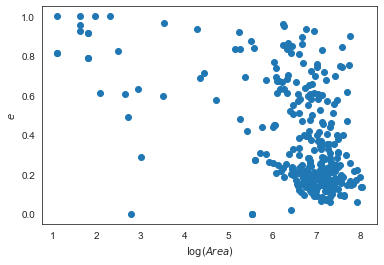

In [20]:
shed_mrkr = remover(shed_mrkr,plotter = True)
plt.savefig(figfile+'eccentricity_vs_area_watershed_seg.png',dpi=300)

Close the segmented image

In [21]:
closed = ski.morphology.closing(shed_mrkr, ski.morphology.disk(3))

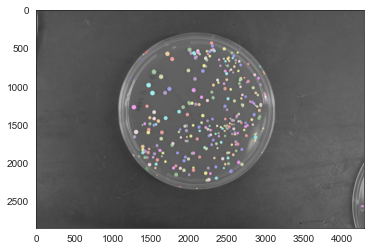

In [22]:
shed_mrkr_rgb = ski.color.label2rgb(closed,image=pic,bg_label=0)
plt.imshow(shed_mrkr_rgb);
plt.savefig(figfile+'bacterial_colony_watershed.png',dpi=300)

# 8.4 Snakes

Construct initial contour

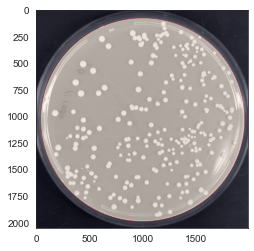

In [23]:
pic_main = pic[300:-500,1100:-1200]
pic_to_seg = np.where(labelled[300:-500,1100:-1200]>0,1.0,0.0)

init_snake = np.zeros(np.shape(pic_to_seg))
r,c = ski.draw.disk((1030,1000),955)
init_snake[r,c] = 1

plt.imshow(pic_main,cmap='gray')
plt.imshow(init_snake,alpha = 0.5);

Evolve the contour for 1000 steps and save image

In [24]:
# Morphological GAC
gimage = ski.segmentation.inverse_gaussian_gradient(pic_to_seg)
snakes = ski.segmentation.morphological_geodesic_active_contour(gimage, 800, init_snake,smoothing=1, balloon=-2)

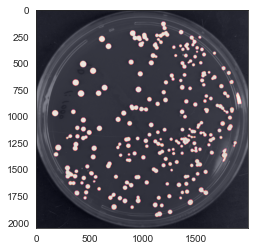

In [25]:
plt.imshow(pic_main, cmap="gray")
plt.imshow(snakes,alpha=0.5);
plt.savefig(figfile+'snakes_bacterial_colony.png',dpi=300)